# CIFAR10 Classification

In this part of the assignment we want to do an image classification task using PyTorch on CIFAR10 dataset.

## Import Libraries

Import needed libraries

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt

## Device

Set device to work with (GPU or CPU)

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Transforms & Dataset & Dataloader

Here, you should download and load the dataset with the desire transforms. After that, you should split train dataset to train and validation sets. Finally, define the dataloaders for `train`, `validation` and `test`

In [ ]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [ ]:
Traintransform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

Testtransform = transforms.Compose([
    transforms.ToTensor(),
])


Trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=Traintransform)
Testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=Testtransform)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
Trainsize = int(0.9 * len(Trainset))
Valsize = len(Trainset) - Trainsize
Trainset, Valset = torch.utils.data.random_split(Trainset, (Trainsize, Valsize))

In [ ]:
Trainloader = torch.utils.data.DataLoader(Trainset, batch_size = 256, shuffle=True, num_workers=2)
Valloader = torch.utils.data.DataLoader(Valset, batch_size = 256, shuffle=True, num_workers=2)
Testloader = torch.utils.data.DataLoader(Testset, batch_size = 1024, shuffle = False, num_workers=4)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


## Visualization

Visualize 5 random images from each class in different columns

- **Hint**:  You can use `plt.subplots` for visualization

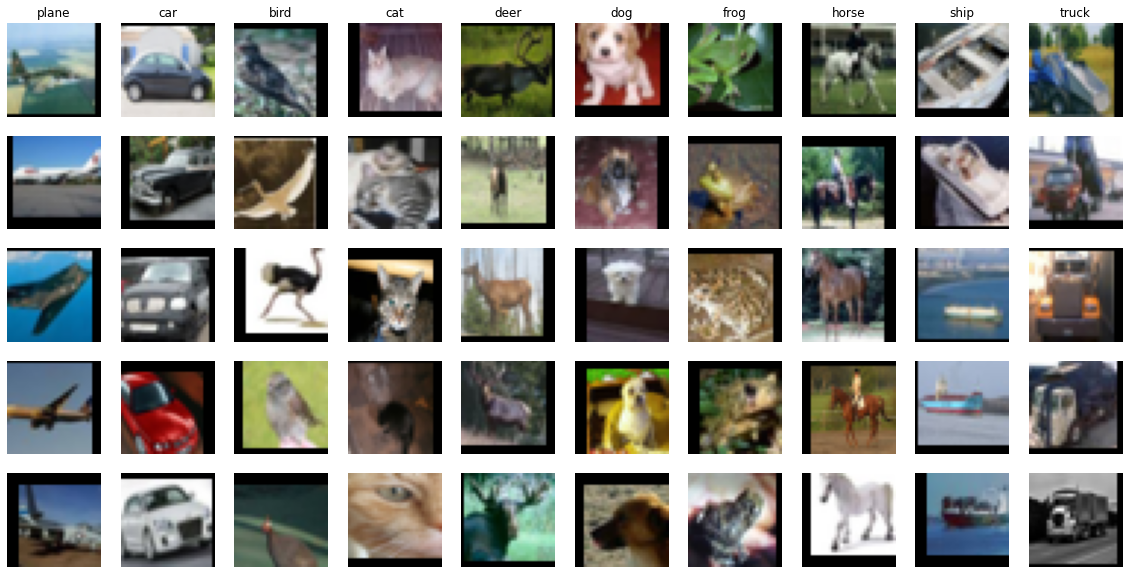

In [ ]:
img_classes = {i: [] for i in range(0, 10)}

counter = 0
i = 0
while counter != 50:
    img, label = Trainset[i]
    if len(img_classes[label]) != 5:
        img_classes[label].append(img)
        counter += 1
        
    i += 1
    
fig = plt.figure(figsize = (20, 10))
for i in range(50):
    fig.add_subplot(5, 10, i + 1)
    plt.imshow(img_classes[i%10][i//10].permute(1,2,0).numpy())
    if i // 10 == 0:
      plt.title(classes[i%10])
    plt.axis('off')
    
plt.show()

## Model

Define your model here from scratch (You are not allowed to use the existing models in pytorch)

**NOTICE:** The model that you will have defined outputs a vector containing 10 numbers (for each class). Define a "feature space" that is a vector of size *N* (where *N > 10*) right before the last layer (You can then have a last layer like `nn.Linear(N, 10)`). See the image below to get a better understanding. We will use this later (we want to access the feature space of a sample when the sample is given to the model). The model tries to learn a representation of the samples in this feature space and we will see how good it could do this in later sections.

![Feature Space In Neural Network](https://i.postimg.cc/28Qjcn9D/feature-space-vis.png)

- **Hint I**: Our goal is to get accuracy above *90%* on testset. Our suggestion is to implement ResNet (ResNet18 could be a viable choice)
  - You can learn the network's structure and implementation online (Youtube, ...) and then implmenet it yourself and make changes to enhance it's performance on our task **(YOU SHOULD NOT COPY THE CODE!!! OTHERWISE, YOU'LL BE PENALIZED!!!)**

- **Hint II**: When defining your model, pay attension to the **NOTICE** part in the above. It's also better to read the "Exploring the feature space" section beforehand.  

In [ ]:

class block(nn.Module):
    def __init__(self, in_channels, out_channels, identity_func=None, stride=1):
        super(block, self).__init__()
        self.identity_func = identity_func
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, stride, 1)
        self.batch1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, 1, 1)
        self.batch2 = nn.BatchNorm2d(out_channels)
        self.relu1 = nn.ReLU()
        
    def forward(self, x):
        identity = x
        x = self.conv1(x)
        x = self.batch1(x)
        x = self.conv2(x)
        x = self.batch2(x)
        
        if self.identity_func is not None:
            identity = self.identity_func(identity)
        
        x += identity
        x = self.relu1(x)
        
        return x
    
class ResNet(nn.Module):
    def __init__(self, block, img_channels, num_classes, layers):
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(img_channels, 64, 3, 1, 1, bias = False)
        self.batch1 = nn.BatchNorm2d(64)
        self.relu1 = nn.ReLU()
        # self.maxpool = nn.MaxPool2d(3, 2, 1)
        
        self.layer1 = self._make_layer(block, layers[0], 64, 1)
        self.layer2 = self._make_layer(block, layers[1], 128, 2)
        self.layer3 = self._make_layer(block, layers[2], 256, 2)
        self.layer4 = self._make_layer(block, layers[3], 512, 2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.batch1(x)
        x = self.relu1(x)
        
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = F.avg_pool2d(x, 4)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)
        
        return x
        
    def get_feature_vector(self, x):
        x = self.conv1(x)
        x = self.batch1(x)
        x = self.relu1(x)
        
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = F.avg_pool2d(x, 4)
        x = x.reshape(x.shape[0], -1)
        return x
        
    def _make_layer(self, block, num_blocks, out_channels, stride):
        layer = []
        identity = None
        
        if stride != 1 or out_channels != 64:
            identity = nn.Sequential(nn.Conv2d(out_channels // 2, out_channels, 1, stride), nn.BatchNorm2d(out_channels))
          
        if out_channels == 64:
            layer.append(block(out_channels, out_channels))
        else:
            layer.append(block(out_channels // 2, out_channels, identity, stride))
        
        
        for _ in range(num_blocks - 1):
            layer.append(block(out_channels, out_channels))
            
        return nn.Sequential(*layer)
    
    
def ResNet18(img_channels, num_classes):
    return ResNet(block, img_channels, num_classes, [2, 2, 2, 2])
      

## Train

### Model instantiation

Create an instance of your model and move it to `device`

In [ ]:
net = ResNet18(3, 10)
net.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (batch1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (layer1): Sequential(
    (0): block(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (batch1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (batch2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU()
    )
    (1): block(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (batch1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (batch2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

### Criterion & Optimizater

Define `criterion` and `optimizer` (Or `scheduler`)

In [ ]:
from torch.optim.lr_scheduler import CosineAnnealingLR
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.SGD(net.parameters(), lr=0.01, momentum = 0.9, weight_decay=0.0002)
scheduler = CosineAnnealingLR(optimizer, T_max = 200)

### Train loop

Train your model 

Tasks:
- [ ] Things that are needed to be printed in each epoch:
  - Number of epoch
  - Train loss
  - Train accuracy
  - Validation loss
  - Validation accuracy
- [ ] save train/validation loss and accuracy (of each epoch) in an array for later usage

In [ ]:
import tqdm

In [ ]:
def train_epoch(model, criterion, optimizer, train_losses, train_accuracies, dataloader):
    model.train()
    
    running_loss = 0
    num_correct = 0
    total = 0
    
    with tqdm.tqdm(enumerate(dataloader), total=len(dataloader)) as pbar:
        for i, (images, labels) in pbar:
            images = images.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
        
            o = model(images)
            loss = criterion(o, labels)
            loss.backward()
            optimizer.step()
        
            running_loss += loss.item()
            _, predict = o.max(1)
            total += labels.size(0)
            num_correct += predict.eq(labels).sum().item()
        
    train_loss = running_loss / len(dataloader)
    train_accuracy = 100.0 * (num_correct/total)
    
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    
    print(f'train loss: {train_loss}, train accuracy: {train_accuracy}')

In [ ]:
def eval_epoch(model, criterion, eval_losses, eval_accuracies, dataloader):
    model.eval()
    
    running_loss = 0
    num_correct = 0
    total = 0
    
    with torch.no_grad(), tqdm.tqdm(enumerate(dataloader), total=len(dataloader)) as pbar:
        for i, (images, labels) in pbar:
            images = images.to(device)
            labels = labels.to(device)
            
            o = model(images)
            loss = criterion(o, labels)
            
            _, predict = o.max(1)
            running_loss += loss.item()
            total += labels.size(0)
            num_correct += predict.eq(labels).sum().item()
    eval_loss = running_loss / len(dataloader)
    eval_accuracy = 100.0 * (num_correct/total)
    
    eval_losses.append(eval_loss)
    eval_accuracies.append(eval_accuracy)
    
    print(f'evaluation loss: {eval_loss}, evaluation accuracy: {eval_accuracy}')

In [ ]:
train_losses = []
train_accuracies = []
eval_losses = []
eval_accuracies = []
epoch = 50
for i in range(1, epoch + 1):
    print(f'Epoch {i}')
    train_epoch(net, criterion, optimizer, train_losses, train_accuracies, Trainloader)
    eval_epoch(net, criterion, eval_losses, eval_accuracies, Valloader)
    scheduler.step()

Epoch 1


100%|██████████| 176/176 [00:42<00:00,  4.13it/s]

train loss: 1.4797863804481246, train accuracy: 45.40222222222222



100%|██████████| 20/20 [00:01<00:00, 12.96it/s]

evaluation loss: 2.1931804358959197, evaluation accuracy: 34.42
Epoch 2



100%|██████████| 176/176 [00:36<00:00,  4.77it/s]

train loss: 1.0381465259600768, train accuracy: 62.84444444444445



100%|██████████| 20/20 [00:01<00:00, 12.87it/s]

evaluation loss: 1.072534629702568, evaluation accuracy: 62.019999999999996
Epoch 3



100%|██████████| 176/176 [00:37<00:00,  4.68it/s]

train loss: 0.8469566960226406, train accuracy: 69.96



100%|██████████| 20/20 [00:01<00:00, 12.62it/s]

evaluation loss: 2.0604726672172546, evaluation accuracy: 45.94
Epoch 4



100%|██████████| 176/176 [00:37<00:00,  4.64it/s]

train loss: 0.7229023613035679, train accuracy: 74.65555555555555



100%|██████████| 20/20 [00:01<00:00, 12.67it/s]

evaluation loss: 0.7670890301465988, evaluation accuracy: 73.02
Epoch 5



100%|██████████| 176/176 [00:37<00:00,  4.67it/s]

train loss: 0.6514724919741804, train accuracy: 77.33333333333333



100%|██████████| 20/20 [00:01<00:00, 12.28it/s]

evaluation loss: 0.675355912744999, evaluation accuracy: 76.12
Epoch 6



100%|██████████| 176/176 [00:38<00:00,  4.63it/s]

train loss: 0.5879668175158176, train accuracy: 79.53333333333333



100%|██████████| 20/20 [00:01<00:00, 12.65it/s]

evaluation loss: 0.6523289531469345, evaluation accuracy: 77.44
Epoch 7



100%|██████████| 176/176 [00:37<00:00,  4.64it/s]

train loss: 0.5275836246596142, train accuracy: 81.72666666666667



100%|██████████| 20/20 [00:01<00:00, 12.88it/s]

evaluation loss: 0.6185547649860382, evaluation accuracy: 78.25999999999999
Epoch 8



100%|██████████| 176/176 [00:37<00:00,  4.64it/s]

train loss: 0.4934598368338563, train accuracy: 82.81333333333333



100%|██████████| 20/20 [00:01<00:00, 12.62it/s]

evaluation loss: 0.5616262227296829, evaluation accuracy: 80.30000000000001
Epoch 9



100%|██████████| 176/176 [00:37<00:00,  4.64it/s]

train loss: 0.4601471205665307, train accuracy: 83.8711111111111



100%|██████████| 20/20 [00:01<00:00, 12.58it/s]

evaluation loss: 0.699486929178238, evaluation accuracy: 76.68
Epoch 10



100%|██████████| 176/176 [00:37<00:00,  4.63it/s]

train loss: 0.4384920278733427, train accuracy: 84.86444444444444



100%|██████████| 20/20 [00:01<00:00, 12.62it/s]

evaluation loss: 0.5562095314264297, evaluation accuracy: 81.26
Epoch 11



100%|██████████| 176/176 [00:38<00:00,  4.62it/s]

train loss: 0.40263036503033206, train accuracy: 85.89777777777778



100%|██████████| 20/20 [00:01<00:00, 12.63it/s]

evaluation loss: 0.5775724500417709, evaluation accuracy: 80.58
Epoch 12



100%|██████████| 176/176 [00:38<00:00,  4.63it/s]

train loss: 0.38415198028087616, train accuracy: 86.7



100%|██████████| 20/20 [00:01<00:00, 12.71it/s]

evaluation loss: 0.5406393840909004, evaluation accuracy: 81.96
Epoch 13



100%|██████████| 176/176 [00:37<00:00,  4.64it/s]

train loss: 0.36993069100109016, train accuracy: 87.2088888888889



100%|██████████| 20/20 [00:01<00:00, 12.82it/s]

evaluation loss: 0.541789910197258, evaluation accuracy: 82.38
Epoch 14



100%|██████████| 176/176 [00:38<00:00,  4.63it/s]

train loss: 0.343195775185119, train accuracy: 87.94222222222223



100%|██████████| 20/20 [00:01<00:00, 12.65it/s]

evaluation loss: 0.48858218640089035, evaluation accuracy: 82.86
Epoch 15



100%|██████████| 176/176 [00:38<00:00,  4.62it/s]

train loss: 0.33005572635341773, train accuracy: 88.43555555555555



100%|██████████| 20/20 [00:01<00:00, 12.75it/s]

evaluation loss: 0.44525638967752457, evaluation accuracy: 85.2
Epoch 16



100%|██████████| 176/176 [00:37<00:00,  4.64it/s]

train loss: 0.30901065333323047, train accuracy: 89.21111111111111



100%|██████████| 20/20 [00:01<00:00, 12.70it/s]

evaluation loss: 0.504262512922287, evaluation accuracy: 83.46000000000001
Epoch 17



100%|██████████| 176/176 [00:38<00:00,  4.63it/s]

train loss: 0.2942925617945465, train accuracy: 89.77555555555556



100%|██████████| 20/20 [00:01<00:00, 12.49it/s]

evaluation loss: 0.47022998332977295, evaluation accuracy: 83.88
Epoch 18



100%|██████████| 176/176 [00:38<00:00,  4.63it/s]

train loss: 0.2817345451224934, train accuracy: 90.11333333333333



100%|██████████| 20/20 [00:01<00:00, 12.84it/s]

evaluation loss: 0.4337091386318207, evaluation accuracy: 86.24000000000001
Epoch 19



100%|██████████| 176/176 [00:37<00:00,  4.64it/s]

train loss: 0.26659577966413717, train accuracy: 90.73777777777778



100%|██████████| 20/20 [00:01<00:00, 12.75it/s]

evaluation loss: 0.44917894154787064, evaluation accuracy: 85.64
Epoch 20



100%|██████████| 176/176 [00:37<00:00,  4.65it/s]

train loss: 0.2536758707666939, train accuracy: 91.07333333333332



100%|██████████| 20/20 [00:01<00:00, 12.46it/s]

evaluation loss: 0.4227951720356941, evaluation accuracy: 86.32
Epoch 21



100%|██████████| 176/176 [00:38<00:00,  4.62it/s]

train loss: 0.2461554411460053, train accuracy: 91.39777777777778



100%|██████████| 20/20 [00:01<00:00, 12.53it/s]

evaluation loss: 0.3914489850401878, evaluation accuracy: 86.78
Epoch 22



100%|██████████| 176/176 [00:38<00:00,  4.63it/s]

train loss: 0.23425349275666205, train accuracy: 91.7911111111111



100%|██████████| 20/20 [00:01<00:00, 12.92it/s]

evaluation loss: 0.4057072252035141, evaluation accuracy: 87.0
Epoch 23



100%|██████████| 176/176 [00:38<00:00,  4.61it/s]

train loss: 0.2266604621809992, train accuracy: 91.91333333333334



100%|██████████| 20/20 [00:01<00:00, 12.44it/s]

evaluation loss: 0.4278361082077026, evaluation accuracy: 86.18
Epoch 24



100%|██████████| 176/176 [00:38<00:00,  4.61it/s]

train loss: 0.2152689954011955, train accuracy: 92.49555555555555



100%|██████████| 20/20 [00:01<00:00, 12.69it/s]

evaluation loss: 0.45307025462388995, evaluation accuracy: 85.66
Epoch 25



100%|██████████| 176/176 [00:38<00:00,  4.61it/s]

train loss: 0.20885338054292582, train accuracy: 92.67777777777778



100%|██████████| 20/20 [00:01<00:00, 12.45it/s]

evaluation loss: 0.39654828459024427, evaluation accuracy: 87.14
Epoch 26



100%|██████████| 176/176 [00:38<00:00,  4.61it/s]

train loss: 0.1967202307741073, train accuracy: 93.00444444444445



100%|██████████| 20/20 [00:01<00:00, 12.64it/s]

evaluation loss: 0.38884436190128324, evaluation accuracy: 87.66000000000001
Epoch 27



100%|██████████| 176/176 [00:38<00:00,  4.61it/s]

train loss: 0.18938334455544298, train accuracy: 93.36222222222223



100%|██████████| 20/20 [00:01<00:00, 12.65it/s]

evaluation loss: 0.40205671787261965, evaluation accuracy: 87.44
Epoch 28



100%|██████████| 176/176 [00:38<00:00,  4.62it/s]

train loss: 0.18409457028081472, train accuracy: 93.42222222222222



100%|██████████| 20/20 [00:01<00:00, 12.51it/s]

evaluation loss: 0.43817234337329863, evaluation accuracy: 87.0
Epoch 29



100%|██████████| 176/176 [00:37<00:00,  4.63it/s]

train loss: 0.1717673746276308, train accuracy: 93.98222222222222



100%|██████████| 20/20 [00:01<00:00, 12.84it/s]

evaluation loss: 0.4089185670018196, evaluation accuracy: 87.7
Epoch 30



100%|██████████| 176/176 [00:38<00:00,  4.62it/s]

train loss: 0.16569719234989447, train accuracy: 94.19333333333333



100%|██████████| 20/20 [00:01<00:00, 12.85it/s]

evaluation loss: 0.4138549745082855, evaluation accuracy: 86.68
Epoch 31



100%|██████████| 176/176 [00:37<00:00,  4.63it/s]

train loss: 0.16234243695031514, train accuracy: 94.21333333333334



100%|██████████| 20/20 [00:01<00:00, 12.57it/s]

evaluation loss: 0.39080353230237963, evaluation accuracy: 87.6
Epoch 32



100%|██████████| 176/176 [00:38<00:00,  4.63it/s]

train loss: 0.15635114484889942, train accuracy: 94.44888888888889



100%|██████████| 20/20 [00:01<00:00, 12.50it/s]

evaluation loss: 0.3869200274348259, evaluation accuracy: 88.08
Epoch 33



100%|██████████| 176/176 [00:38<00:00,  4.62it/s]

train loss: 0.1481296617791734, train accuracy: 94.77333333333333



100%|██████████| 20/20 [00:01<00:00, 12.68it/s]

evaluation loss: 0.39365802258253096, evaluation accuracy: 87.94
Epoch 34



100%|██████████| 176/176 [00:38<00:00,  4.62it/s]

train loss: 0.14308247321539305, train accuracy: 94.81555555555555



100%|██████████| 20/20 [00:01<00:00, 12.61it/s]

evaluation loss: 0.36909202486276627, evaluation accuracy: 88.96
Epoch 35



100%|██████████| 176/176 [00:37<00:00,  4.63it/s]

train loss: 0.13316356792876666, train accuracy: 95.25333333333333



100%|██████████| 20/20 [00:01<00:00, 12.77it/s]

evaluation loss: 0.3979259207844734, evaluation accuracy: 87.88
Epoch 36



100%|██████████| 176/176 [00:38<00:00,  4.63it/s]

train loss: 0.13337110719558867, train accuracy: 95.2488888888889



100%|██████████| 20/20 [00:01<00:00, 12.55it/s]

evaluation loss: 0.38732636868953707, evaluation accuracy: 88.08
Epoch 37



100%|██████████| 176/176 [00:38<00:00,  4.63it/s]

train loss: 0.12267732620239258, train accuracy: 95.65777777777778



100%|██████████| 20/20 [00:01<00:00, 12.50it/s]

evaluation loss: 0.3814509466290474, evaluation accuracy: 88.96
Epoch 38



100%|██████████| 176/176 [00:38<00:00,  4.63it/s]

train loss: 0.1212623434733938, train accuracy: 95.71777777777778



100%|██████████| 20/20 [00:01<00:00, 12.79it/s]

evaluation loss: 0.3747373640537262, evaluation accuracy: 88.75999999999999
Epoch 39



100%|██████████| 176/176 [00:38<00:00,  4.62it/s]

train loss: 0.11921719152649696, train accuracy: 95.70666666666666



100%|██████████| 20/20 [00:01<00:00, 12.56it/s]

evaluation loss: 0.39170499742031095, evaluation accuracy: 88.8
Epoch 40



100%|██████████| 176/176 [00:38<00:00,  4.61it/s]

train loss: 0.10768590939485213, train accuracy: 96.16



100%|██████████| 20/20 [00:01<00:00, 12.46it/s]

evaluation loss: 0.4052355960011482, evaluation accuracy: 87.78
Epoch 41



100%|██████████| 176/176 [00:38<00:00,  4.61it/s]

train loss: 0.10847310048782012, train accuracy: 96.15555555555557



100%|██████████| 20/20 [00:01<00:00, 12.56it/s]

evaluation loss: 0.4170085430145264, evaluation accuracy: 88.14
Epoch 42



100%|██████████| 176/176 [00:38<00:00,  4.61it/s]

train loss: 0.10415965841490436, train accuracy: 96.35777777777777



100%|██████████| 20/20 [00:01<00:00, 12.55it/s]

evaluation loss: 0.3979936301708221, evaluation accuracy: 88.88000000000001
Epoch 43



100%|██████████| 176/176 [00:38<00:00,  4.61it/s]

train loss: 0.09549855614419687, train accuracy: 96.66



100%|██████████| 20/20 [00:01<00:00, 12.35it/s]

evaluation loss: 0.3585794687271118, evaluation accuracy: 89.34
Epoch 44



100%|██████████| 176/176 [00:38<00:00,  4.62it/s]

train loss: 0.09125380842438476, train accuracy: 96.77333333333334



100%|██████████| 20/20 [00:01<00:00, 12.57it/s]

evaluation loss: 0.4111002653837204, evaluation accuracy: 88.56
Epoch 45



100%|██████████| 176/176 [00:38<00:00,  4.61it/s]

train loss: 0.0872093073240566, train accuracy: 96.90666666666667



100%|██████████| 20/20 [00:01<00:00, 12.50it/s]

evaluation loss: 0.3883546471595764, evaluation accuracy: 89.12
Epoch 46



100%|██████████| 176/176 [00:38<00:00,  4.61it/s]

train loss: 0.08424305083992129, train accuracy: 96.98444444444443



100%|██████████| 20/20 [00:01<00:00, 12.42it/s]

evaluation loss: 0.3834355600178242, evaluation accuracy: 88.96
Epoch 47



100%|██████████| 176/176 [00:38<00:00,  4.62it/s]

train loss: 0.08387926451607862, train accuracy: 96.96000000000001



100%|██████████| 20/20 [00:01<00:00, 12.72it/s]

evaluation loss: 0.3798205628991127, evaluation accuracy: 89.44
Epoch 48



100%|██████████| 176/176 [00:38<00:00,  4.61it/s]

train loss: 0.07868609226054767, train accuracy: 97.21555555555555



100%|██████████| 20/20 [00:01<00:00, 10.73it/s]

evaluation loss: 0.4270767763257027, evaluation accuracy: 88.26
Epoch 49



100%|██████████| 176/176 [00:38<00:00,  4.61it/s]

train loss: 0.08068320021795278, train accuracy: 97.13555555555556



100%|██████████| 20/20 [00:01<00:00, 12.49it/s]

evaluation loss: 0.3559344783425331, evaluation accuracy: 90.14
Epoch 50



100%|██████████| 176/176 [00:38<00:00,  4.62it/s]

train loss: 0.07170246661090376, train accuracy: 97.48666666666666



100%|██████████| 20/20 [00:01<00:00, 12.57it/s]

evaluation loss: 0.3815823018550873, evaluation accuracy: 89.38000000000001


### Visualize Loss and Accuracy plot

Using the arrays that you have (from task 2 in the above section), visualize two plots: Accuracy plot (train and validation together) and Loss plot (train and validation together)

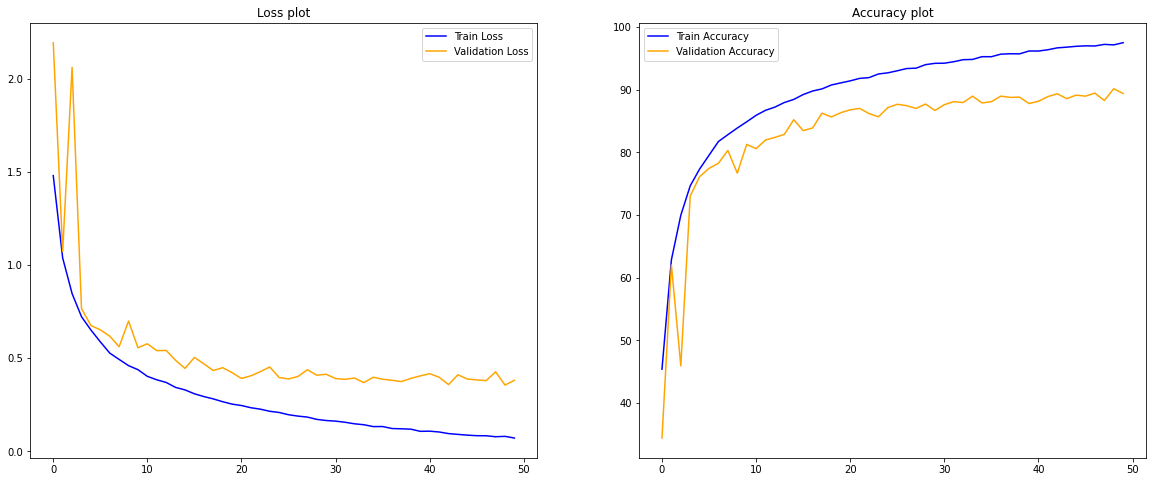

In [ ]:
fig = plt.figure(figsize=(20, 8))

fig.add_subplot(1, 2, 1)
plt.plot(train_losses, color = 'blue', label = 'Train Loss')
plt.plot(eval_losses, color = 'orange', label = 'Validation Loss')
plt.title('Loss plot')
plt.legend(loc ='upper right')

fig.add_subplot(1, 2, 2)
plt.plot(train_accuracies, color = 'blue', label = 'Train Accuracy')
plt.plot(eval_accuracies, color = 'orange', label = 'Validation Accuracy')
plt.title('Accuracy plot')
plt.legend(loc='upper left')

## Evaluation

Test your trained model (using the Test Dataloader that you have). Our goal is to reach an accuracy above `90%`

In [ ]:
eval_epoch(net, criterion, [], [], Testloader)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 10/10 [00:03<00:00,  3.27it/s]

evaluation loss: 0.3970634937286377, evaluation accuracy: 90.06


## Visualize incorrectly predicted samples from testset

Visualize *24* random images from testset that are incorrectly predicted by the model

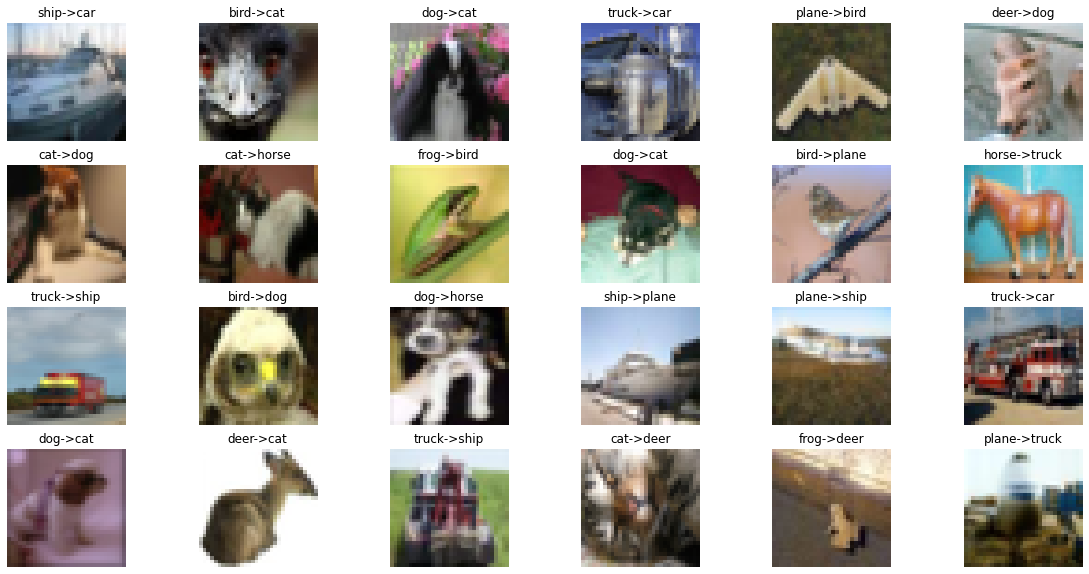

In [ ]:
image_list = []
i = 0
while len(image_list) < 25:
  img, label = Testset[i]
  x = img.unsqueeze(0)
  x = x.to(device)
  y = net(x)
  _, predict = y.max(1)
  if predict != label:
    image_list.append([img, label, predict])
  i += 1

fig = plt.figure(figsize = (20, 10))
for i in range(24):
  fig.add_subplot(4, 6, i + 1)
  plt.imshow(image_list[i][0].permute(1, 2, 0).numpy())
  plt.title(str(classes[image_list[i][1]]) + '->' + str(classes[image_list[i][2]]))
  plt.axis('off')



## Exploring the feature space

### Calculate the feature space for all training samples

You have trained and evaluated your model. Now, for each sample in the trainset, calculate it's "feature space" discussed in the model section. The result of this section should be a tensor of size `(50000, N)` saved in a variable (for later usage)

- **Hint 1:** define a tensor with dimension `(50000, N)` where *50000* is the size of the trainset and *N* is the dimension of the feature space

- **Hint 2:** Pay attension to the `shuffle` attribute of your train dataloader (If needed)

In [ ]:
device = 'cpu'

In [ ]:
T = Trainset + Valset
dataloader = torch.utils.data.DataLoader(T, batch_size = 1, shuffle = False, num_workers = 1)

feature_space = torch.zeros(50000, 512)
net.to(device)
net.eval()
for i, (img, label) in enumerate(dataloader):
  vector = net.get_feature_vector(img.to(device))
  vector = vector.detach()
  feature_space[i-1] = vector

feature_space.shape

torch.Size([50000, 512])

### K Nearest Neighbor in feature space

You already have calculated the feature spaces for trainset ($S$) in the previous section

1. Get 5 random samples from testset which are correctly predicted by the model. 
2. for each sample, calculate it's "feature space" ($X$)
3. for each sample, calculate it's *5* nearest neighbors in "feature space" in the trainset (by comparing $X$ to each row in $S$) and visualize them

**Note:** Your visualization should be something like the below picture

**Hint:** For finding the nearest neighbors in the feature space you can use `torch.linalg.norm` and `torch.topk`

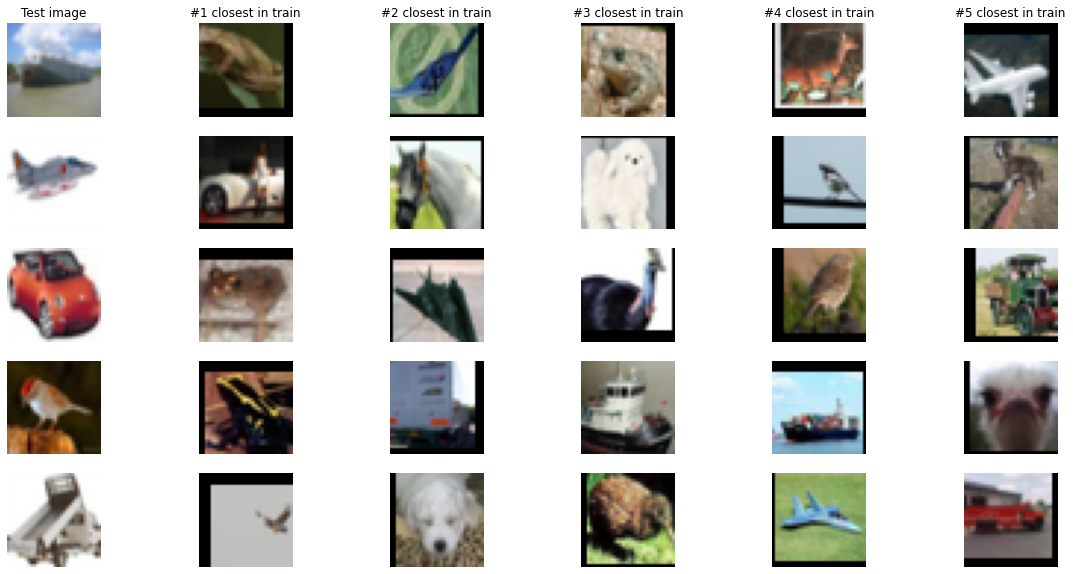

In [ ]:
import random

def get_nearest(feature, feature_vector):
  difference = feature - feature_vector
  normed = torch.linalg.norm(difference, dim = 1)
  results = torch.topk(normed, 5, largest = False)
  return results.indices[0:]

test_samples = []
while len(test_samples) < 5:
  index = random.randint(0, len(Testset) - 1)
  img, label = Testset[index]
  x = img.to(device)
  x = x.unsqueeze(0)
  y = net(x)
  _, predict = y.max(1)
  if (predict == label):
    test_samples.append(img)

fig = plt.figure(figsize = (20, 10))

for i in range(len(test_samples)):
  vector = net.get_feature_vector(test_samples[i].unsqueeze(0))
  indexes = get_nearest(feature_space, vector)
  fig.add_subplot(5, 6, 6 * i + 1)
  plt.imshow(test_samples[i].permute(1, 2, 0).numpy())
  plt.axis('off')
  if (i == 0):
    plt.title('Test image')

  for j in range(1, 6):
    fig.add_subplot(5, 6, 6 * i + 1 + j)
    
    plt.imshow(T[indexes[j-1]][0].permute(1, 2, 0).numpy())
    plt.axis('off')
    if (i == 0):
      plt.title(f'#{j} closest in train')


### TSNE 

1. Sample $M$ ($2000$ would be enought) random samples from the trainset feature space (calculated in the above sections) 
2. Now you a vector of size `(M, N)` where $N$ is the dimension of the feature space
3. Using TSNE reduce $N$ to $2$ (Now you have a vector of size `(M, 2)`)
4. Print the shape of the output

**Hint:** You can use `sklearn.manifold.TSNE`

In [ ]:
from sklearn.manifold import TSNE
random_indexes = torch.randperm(len(feature_space))
selected_indexes = random_indexes[:2000]
selected_vectors = feature_space[selected_indexes]
y = net.fc(selected_vectors)
_, class_predict = y.max(1)
class_predict = class_predict.numpy()

model = TSNE(n_components = 2, random_state = 0, learning_rate = 'auto', init = 'random')
reduced_vectors = model.fit_transform(selected_vectors)
reduced_vectors.shape

(2000, 2)

Visualize the points in a 2D plane (Set color of each point based on it's class)

**Notice:** Your visualization should be something like the below image

**Hint:** Use `plt.scatter(x, y, c=labels)`

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Unrecognized location 'upper-right'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  


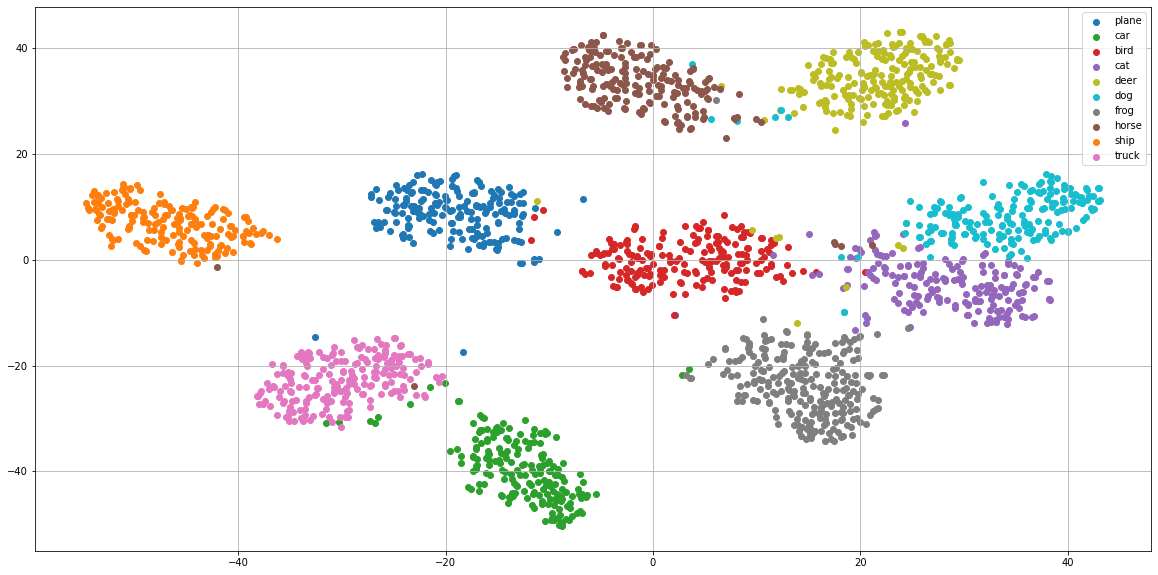

In [ ]:
classes_indexes = {i: [] for i in range(10)}

zip_data = list(zip(reduced_vectors, class_predict))

colors = ['tab:blue', 'tab:green', 'tab:red', 'tab:purple', 'tab:olive', 'tab:cyan', 'tab:grey', 'tab:brown', 'tab:orange', 'tab:pink']

fig, ax = plt.subplots(figsize = (20, 10))
for i in range(10):
  color = colors[i]
  clas = classes[i]
  data = torch.tensor([x[0] for x in zip_data if x[1] == i])
  ax.scatter(data[:, 0], data[:, 1], c = color, label = clas)

ax.legend(loc = 'upper-right')
ax.grid(True)

plt.show()